In [1]:
%%capture
!pip install opendatasets

In [2]:
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/debasisdotcom/name-entity-recognition-ner-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: username
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/debasisdotcom/name-entity-recognition-ner-dataset


100%|██████████| 3.17M/3.17M [00:00<00:00, 124MB/s]

## Load dataset

In [41]:
import pandas as pd
from sklearn import preprocessing

df = pd.read_csv('name-entity-recognition-ner-dataset/NER dataset.csv', encoding='unicode_escape')
df.columns = ['Sentence', 'Word', 'POS', 'Tag']
df["Sentence"] = df["Sentence"].fillna(method='ffill')
df['Tag'] = df['Tag'].map(lambda x: x.upper())
df["Word"].fillna("None", inplace=True)
df.head()

<ipython-input-41-70fef115b0ca>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Sentence"] = df["Sentence"].fillna(method='ffill')


,Sentence,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [42]:
df['Tag'].unique()

array(['O', 'B-GEO', 'B-GPE', 'B-PER', 'I-GEO', 'B-ORG', 'I-ORG', 'B-TIM',
       'B-ART', 'I-ART', 'I-PER', 'I-GPE', 'I-TIM', 'B-NAT', 'B-EVE',
       'I-EVE', 'I-NAT'], dtype=object)

Create color map for tags

In [3]:
color_mapping = {}
# create a color map.
list_suffixes = []
for tag in df['Tag'].unique():
  if tag == 'O':
    color_mapping[tag] = ''
  else:
    suffix = tag.split('-')[1]
    if suffix not in list_suffixes:
      list_suffixes.append(suffix)
    # create color based of index of suffix in the list
    color_mapping[tag] = f'\033[1{str(list_suffixes.index(suffix)).zfill(2)}m'

def display_formatted_text(words, tags):
    """
    Highlight words based on their tags. \033[0m is the ANSI escape code to reset formatting.
    """
    formatted_text = " ".join([color_mapping[tag] + word + '\033[0m' for word, tag in zip(words, tags)])
    print(formatted_text)

In [43]:
label_encoder = preprocessing.LabelEncoder()
df['Tag_Encoded']= label_encoder.fit_transform(df['Tag'])

In [44]:
# label encode TAG
label_encoder = preprocessing.LabelEncoder()
df['Tag_Encoded']= label_encoder.fit_transform(df['Tag'])
# aggregate into list based on sentence
df = df.groupby('Sentence').agg(list).reset_index().drop(['Sentence'], axis=1)
df.head(2)

,Word,POS,Tag,Tag_Encoded
0,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO...","[16, 16, 16, 16, 16, 16, 2, 16, 16, 16, 16, 16..."
1,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-GPE, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[3, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16..."


In [6]:
display_formatted_text(df['Word'][0], df['Tag'][0])

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .


## Prepare dataset for training

In [9]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
import numpy as np
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
SW_english = stopwords.words('english')

def extract_features(word, post_word, len_sentence):
  """
  Extract the features of each WORD
  """
  features = {
      'capitalizedFirst': word[0].isupper(),
      'capitalizedAll': word.isupper(),
      'len_word': len(word),
      'pos_word': post_word/len_sentence,
      'is_numeric': word.isdigit(),
      'is_stopword': word in SW_english,
      'is_punctuation': word in string.punctuation
  }
  return features

# Create feature vectors and labels
X = []
Y = []
for i in range(len(df)):
    sentence = df['Word'][i]
    tags = df['Tag_Encoded'][i]
    for pos, (word, tag) in enumerate(zip(sentence, tags)):
        X.append(extract_features(word, pos, len(sentence)))
        Y.append(tag)

# Vectorize features
vectorizer = DictVectorizer(sparse=False)
X_vectorized = vectorizer.fit_transform(X)
Y = np.array(Y)

In [11]:
print(X_vectorized.shape)
print(Y.shape)

(1048575, 7)
(1048575,)


Split dataset into train/test

## Multi-class classification

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, Y, test_size=0.2, random_state=42)

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

We use SVM as classifier, with balanced class weight to deal with class imbalance

In [15]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

SEED = 42
# linearSVC one-vs-rest, we have like 16 classes so one-vs-one is costly
model = LinearSVC(C = 1.0, class_weight = "balanced", random_state = SEED)
model.fit(X_train, y_train)

LinearSVC(class_weight='balanced', random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.00      0.00      0.00        64
           2       0.31      0.40      0.35      7610
           3       0.14      0.46      0.22      3237
           4       0.01      0.15      0.02        39
           5       0.37      0.17      0.23      3992
           6       0.11      0.40      0.17      3352
           7       0.00      0.00      0.00      3937
           8       0.00      0.00      0.00        56
           9       0.01      0.35      0.01        52
          10       0.00      0.00      0.00      1521
          11       0.00      0.00      0.00        35
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00      3259
          14       0.00      0.00      0.00      3476
          15       0.21      0.39      0.27      1304
          16       0.99      0.94      0.96    177688

    accuracy              

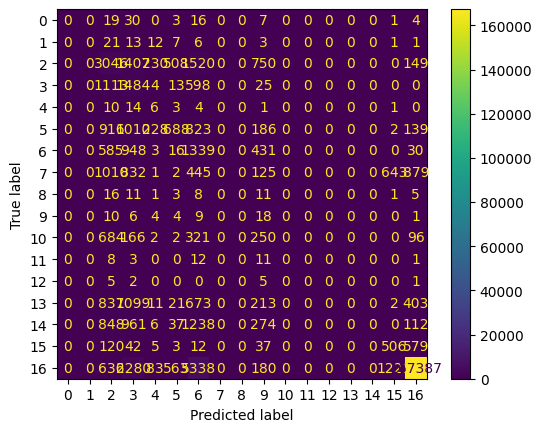

In [16]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [70]:
def inference(clf, sentence, binary=False):
  # for this data set since it separate the punctuation, better use spacy pipeline to process
  assert isinstance(sentence, list)
  result_tags = []
  x = []
  for i in range(len(sentence)):
    x.append(extract_features(sentence[i], i, len(sentence)))
  x = vectorizer.transform(x)
  x = scaler.transform(x)
  y_pred = clf.predict(x)
  if not binary:
    tags = label_encoder.inverse_transform(y_pred)
  else:
    tags = list(y_pred)
  print(tags)
  display_formatted_text(sentence, tags)

Test the model

In [35]:
inference(model, df['Word'][0])
print("\n")
inference(model, df['Word'][5])

['B-GPE' 'O' 'O' 'O' 'O' 'O' 'B-PER' 'O' 'O' 'O' 'O' 'O' 'I-EVE' 'O' 'O'
 'O' 'O' 'O' 'B-GEO' 'O' 'O' 'O' 'O' 'O']
Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .


['B-PER' 'B-GPE' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'B-GEO' 'O' 'I-EVE' 'B-GEO' 'O' 'O' 'B-GEO' 'O'
 'B-GEO' 'O']
Mr. Egeland said the latest figures show 1.8 million people are in need of food assistance - with the need greatest in Indonesia , Sri Lanka , the Maldives and India .


The result for multi-class is quite bad. Maybe the extracted features are not good enough for 16 classes, also the imbalance of dataset (lots of 'O'). Also it lacks of context of the word (words that precede or follow current word)

## Binary classification
Here we define the class as entities or not, simplify the problem into binary classification

In [45]:
df['Tag_binary'] = df['Tag'].map(lambda x: [0 if a=='O' else 1 for a in x])
df.head(2)

,Word,POS,Tag,Tag_Encoded,Tag_binary
0,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-GEO, O, O, O, O, O, B-GEO...","[16, 16, 16, 16, 16, 16, 2, 16, 16, 16, 16, 16...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-GPE, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[3, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [46]:
# Create feature vectors and labels
X = []
Y = []
for i in range(len(df)):
    sentence = df['Word'][i]
    tags = df['Tag_binary'][i]
    for pos, (word, tag) in enumerate(zip(sentence, tags)):
        X.append(extract_features(word, pos, len(sentence)))
        Y.append(tag)

# Vectorize features
vectorizer = DictVectorizer(sparse=False)
X_vectorized = vectorizer.fit_transform(X)
Y = np.array(Y)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, Y, test_size=0.2, random_state=42)

In [51]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [52]:
SEED = 42
model = LinearSVC(C = 1.0, class_weight = "balanced", random_state = SEED)
model.fit(X_train, y_train)

LinearSVC(class_weight='balanced', random_state=42)

              precision    recall  f1-score   support

           0       0.99      0.94      0.96    177688
           1       0.74      0.93      0.82     32027

    accuracy                           0.94    209715
   macro avg       0.86      0.93      0.89    209715
weighted avg       0.95      0.94      0.94    209715



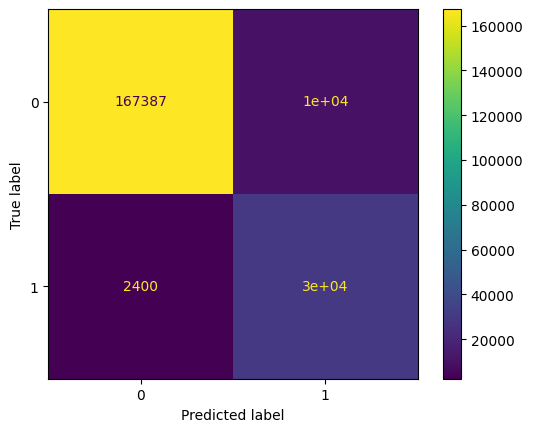

In [53]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [71]:
color_mapping[1] = '\x1b[101m'
color_mapping[0] = ''

print(df['Tag_binary'][0])
inference(model, df['Word'][0], binary=True)
print("\n")
print(df['Tag_binary'][5])
inference(model, df['Word'][5], binary=True)
print("\n")
print(df['Tag_binary'][6])
inference(model, df['Word'][6], binary=True)
print("\n")
print(df['Tag_binary'][7])
inference(model, df['Word'][7], binary=True)

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .


[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Mr. Egeland said the latest figures show 1.8 million people are in need of food assistance - with the need greatest in Indonesia , Sri Lanka , the Maldives and India .


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
He said last week 's tsunami and the massive underwater earthquake that triggered it has affected millions in Asia and Africa .


[0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0]
Some 1,27,000 people are known dea

The result is much better when there is only 2 classes. But we could observe that the first word of sentences are often classified as an entity